In [1]:

using GLM
using DataFrames #NB: we are using pinned version 0.9.1 to match JuliaBox
using FreqTables
using Plots
using StatPlots
using Distributions
using RDatasets
using Suppressor
using DecisionTree
#https://github.com/JuliaLang/IJulia.jl/issues/448

function nfoldCV(classifier::Symbol,labels, features,maxdepth, args...)
    nfolds = args[end]
    if nfolds < 2
        return nothing
    end
    if classifier == :tree
        pruning_purity = args[1]
    elseif classifier == :forest
        nsubfeatures = args[1]
        ntrees = args[2]
        partialsampling = args[3]
    elseif classifier == :stumps
        niterations = args[1]
    end
    N = length(labels)
    ntest = _int(floor(N / nfolds))
    inds = randperm(N)
    accuracy = zeros(nfolds)
    for i in 1:nfolds
        test_inds = falses(N)
        test_inds[(i - 1) * ntest + 1 : i * ntest] = true
        train_inds = (!).(test_inds)
        test_features = features[inds[test_inds],:]
        test_labels = labels[inds[test_inds]]
        train_features = features[inds[train_inds],:]
        train_labels = labels[inds[train_inds]]
        if classifier == :tree
            model = build_tree(train_labels, train_features, 0,maxdepth)
            if pruning_purity < 1.0
                model = prune_tree(model, pruning_purity)
            end
            predictions = apply_tree(model, test_features)
        elseif classifier == :forest
            model = build_forest(train_labels, train_features, nsubfeatures, ntrees, partialsampling)
            predictions = apply_forest(model, test_features)
        elseif classifier == :stumps
            model, coeffs = build_adaboost_stumps(train_labels, train_features, niterations)
            predictions = apply_adaboost_stumps(model, coeffs, test_features)
        end
        cm = confusion_matrix(test_labels, predictions)
        accuracy[i] = cm.accuracy
        
    end

    return accuracy
end

nfoldCV (generic function with 1 method)

##  Overview
 * Supervised Learning
 * (Genarlised) Linear Models  
 * Classification and Regression Trees
 * Neural Netwsorks




 


## Elements of supervised learning

 * Data set is collections of features $x_i$ and labels $y_i$ and the task  is to predict $y_i$ given $x_i$. A model can be formed on the basis of a training set $(x_i,y_i)_i$.
 * model is the mathematical structure to predict $Y$ from $x$ e.g. $Y=X \cdot \beta$ for a linear model
 * a model consists of parameters e.g. $\beta$ to be choosen
 * solving the learning tasks boils down to optimising $\beta$ e.g.
 $$ \text{obj}(\beta)=L(\beta)+\Omega(\beta) $$
 where $L(\theta) = \sum_i (y_i-\hat{y}_i(\beta))^2$ is the loss and $\Omega$ the regulariser (prevents over-fitting)
 * Side remark: Bayesian approach


(following XGBoost tutorial)

## Overfitting
![png](step_fit.png)

# (Generalised) Linear Models

The simplest and most underestimated models are linear models.

$Y=X\beta+\epsilon$

where $X\in \mathbb{R}^{n\times p}$ (predictor,feature), Y (response) and  $\epsilon$ is the noise and in the simplest setting is modelled as $\epsilon\sim\mathcal{N}(0,\sigma I)$.
 * The maximum likelihood estimator $$\hat{\beta}_{OLS}= \text{argmax}_\beta p(Y|\beta)\propto \exp\left( -\frac{1}{2} (Y-X\beta)^t (Y-X\beta) \right)$$.
Important considerations
    * $n\ll p$ - variable selection or regularisation needs to be performed
    * we would like as many entries of $\beta$ to be zero
Pointers 
 * Richard Samworth on Linear Models https://www.youtube.com/watch?v=5m3djtMGyHs
 * Here I follow James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112). New York: springer. P.
 * Elements of Statistical learning

Minimising quadratic form = solving linear equation

In [2]:
boston=readtable("boston.csv")
head(boston)

6×14 DataFrames.DataFrame
│ Row │ Crim    │ Zn   │ Indus │ Chas │ NOx   │ Rm    │ Age  │ Dis    │ Rad │
├─────┼─────────┼──────┼───────┼──────┼───────┼───────┼──────┼────────┼─────┤
│ 1   │ 0.00632 │ 18.0 │ 2.31  │ 0    │ 0.538 │ 6.575 │ 65.2 │ 4.09   │ 1   │
│ 2   │ 0.02731 │ 0.0  │ 7.07  │ 0    │ 0.469 │ 6.421 │ 78.9 │ 4.9671 │ 2   │
│ 3   │ 0.02729 │ 0.0  │ 7.07  │ 0    │ 0.469 │ 7.185 │ 61.1 │ 4.9671 │ 2   │
│ 4   │ 0.03237 │ 0.0  │ 2.18  │ 0    │ 0.458 │ 6.998 │ 45.8 │ 6.0622 │ 3   │
│ 5   │ 0.06905 │ 0.0  │ 2.18  │ 0    │ 0.458 │ 7.147 │ 54.2 │ 6.0622 │ 3   │
│ 6   │ 0.02985 │ 0.0  │ 2.18  │ 0    │ 0.458 │ 6.43  │ 58.7 │ 6.0622 │ 3   │

│ Row │ Tax │ PTRatio │ Black  │ LStat │ MedV │
├─────┼─────┼─────────┼────────┼───────┼──────┤
│ 1   │ 296 │ 15.3    │ 396.9  │ 4.98  │ 24.0 │
│ 2   │ 242 │ 17.8    │ 396.9  │ 9.14  │ 21.6 │
│ 3   │ 242 │ 17.8    │ 392.83 │ 4.03  │ 34.7 │
│ 4   │ 222 │ 18.7    │ 394.63 │ 2.94  │ 33.4 │
│ 5   │ 222 │ 18.7    │ 396.9  │ 5.33  │ 36.2 │
│ 6   │ 222 │ 18.7    │ 394.12 │ 5.21  │ 28.7 │

In [3]:
describe(boston)

Crim
Summary Stats:
Mean:           3.613524
Minimum:        0.006320
1st Quartile:   0.082045
Median:         0.256510
3rd Quartile:   3.677083
Maximum:        88.976200
Length:         506
Type:           Float64
Number Missing: 0
% Missing:      0.000000

Zn
Summary Stats:
Mean:           11.363636
Minimum:        0.000000
1st Quartile:   0.000000
Median:         0.000000
3rd Quartile:   12.500000
Maximum:        100.000000
Length:         506
Type:           Float64
Number Missing: 0
% Missing:      0.000000

Indus
Summary Stats:
Mean:           11.136779
Minimum:        0.460000
1st Quartile:   5.190000
Median:         9.690000
3rd Quartile:   18.100000
Maximum:        27.740000
Length:         506
Type:           Float64
Number Missing: 0
% Missing:      0.000000

Chas
Summary Stats:
Mean:           0.069170
Minimum:        0.000000
1st Quartile:   0.000000
Median:         0.000000
3rd Quartile:   0.000000
Maximum:        1.000000
Length:         506
Type:           Int64
Number 

We aim to predict (median house value)
medv using 13 predictors such as rm (average number of rooms per house), age (average age of houses), and lstat (percent of households with low socioeconomic status).


In [4]:
using Suppressor

In [6]:
@suppress fitols=lm(@formula( MedV~LStat),boston)
coef((fitols))

2-element Array{Float64,1}:
 34.5538  
 -0.950049

In [7]:
p1=scatter(boston[:LStat],boston[:MedV],) 
xs=[1.0:40;]
plot!(xs,GLM.predict(fitols,DataFrame(LStat=xs)))


<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
 40 
 
 
 0 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
 40 
 
 
 50 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip0802)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 44.7288,127.474 58.0618,133.579 71.3948,139.684 84.7278,145.789 98.0608,151.894 111.394,157.999 124.727,164.104 138.06,170.209 151.393,176.314 164.726,182.418 
 178.059,188.523 191.392,194.628 204.725,200.733 218.058,206.838 231.391,212.943 244.724,219.048 258.057,225.153 271.39,231.258 284.723,237.362 298.056,243.467 
 311.389,249.572 324.722,255.677 338.055,261.782 351.388,267.887 364.721,273.992 378.054,280.097 391.387,286.202 404.719,292.306 418.052,298.411 431.385,304.516 
 444.718,310.621 458.051,316.726 471.384,322.831 484.717,328.936 498.05,335.041 511.383,341.146 524.716,347.25 538.049,353.355 551.382,359.46 564.715,365.565 
 
 "/>
 
 
 
 
 
 y1 
 
 
 
 y2

In [8]:
confint(fitols)

2×2 Array{Float64,2}:
 33.4485   35.6592  
 -1.02615  -0.873951

In [9]:

@show GLM.r2(fitols)
p=scatter(GLM.predict(fitols),residuals(fitols)/var(residuals(fitols))^0.5)
xlabel!("fitted")
ylabel!("standardised residuals")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 fitted 
 
 
 standardised residuals 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 y1


A common diagnostic used in statistics is the q-q plot. If we assume
data $X_{i}\overset{\text{iid}}{\sim} F$ where $F(t)=\mathbb{P}(X\leq t)$, then the q-q
plot is a plot of 
\begin{align*}
 & (F^{-1}(q),\hat{F}_{n}^{-1}(q))\;\tag{q-q plot}
\end{align*}
where $\hat{F}_{n}(t)$ is the empirical cdf given by 

$$
\hat{F}_{n}(t)=\frac{\mbox{number of elements in the sample}\leq t}{n}=\frac{1}{n}\sum_{i=1}^{n}\mathbf{1}_{X_{i}\le t}
$$
and $F^{-1}$ denotes the generalised inverse distribution function
given by 
$$
F^{-1}(p)=\inf\{x\in\mathbb{R}:F(x)\geq p\}.
$$
If $F$ is invertible, we can equivalently plot $\left(x,\hat{F}_{n}^{-1}(F(x))\right)$.
Provided $X_{i} \overset{\text{iid}}{\sim} F$ and $n$ is large $\hat{F}_{n}\approx F$
such that $F^{-1}(\hat{F}_{n}(t))$ and the plot would correspond
to a straight line. 


In [10]:
 @suppress qqplot(randn(500),Normal())
title!("QQ-Plot")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 -3 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 QQ-Plot

In [11]:
@suppress qqplot(residuals(fitols)/var(residuals(fitols))^0.5,Normal())

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 -2 
 
 
 0 
 
 
 2 
 
 
 4

In [12]:
# Multiple linear regression
fitols=lm(@formula( MedV~LStat+Age),boston)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: MedV ~ 1 + LStat + Age

Coefficients:
              Estimate Std.Error  t value Pr(>|t|)
(Intercept)    33.2228  0.730847  45.4579   <1e-99
LStat         -1.03207 0.0481907 -21.4163   <1e-72
Age          0.0345443 0.0122255   2.8256   0.0049


In [13]:
fitols=lm(@formula( MedV~LStat+(AgeSq)),hcat(boston,DataFrame(AgeSq=boston[:Age].^2)))

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: MedV ~ 1 + LStat + AgeSq

Coefficients:
                Estimate   Std.Error t value Pr(>|t|)
(Intercept)      34.0272    0.582751 58.3906   <1e-99
LStat           -1.04702   0.0493877   -21.2   <1e-71
AgeSq        0.000319224 0.000102238 3.12236   0.0019


### The Auto Data for Lineer Regression (For L8-Assignment):

In [14]:
auto_data=readtable("Auto.csv")
head(auto_data)

6×9 DataFrames.DataFrame
│ Row │ mpg  │ cylinders │ displacement │ horsepower │ weight │ acceleration │
├─────┼──────┼───────────┼──────────────┼────────────┼────────┼──────────────┤
│ 1   │ 18.0 │ 8         │ 307.0        │ "130"      │ 3504   │ 12.0         │
│ 2   │ 15.0 │ 8         │ 350.0        │ "165"      │ 3693   │ 11.5         │
│ 3   │ 18.0 │ 8         │ 318.0        │ "150"      │ 3436   │ 11.0         │
│ 4   │ 16.0 │ 8         │ 304.0        │ "150"      │ 3433   │ 12.0         │
│ 5   │ 17.0 │ 8         │ 302.0        │ "140"      │ 3449   │ 10.5         │
│ 6   │ 15.0 │ 8         │ 429.0        │ "198"      │ 4341   │ 10.0         │

│ Row │ year │ origin │ name                        │
├─────┼──────┼────────┼─────────────────────────────┤
│ 1   │ 70   │ 1      │ "chevrolet chevelle malibu" │
│ 2   │ 70   │ 1      │ "buick skylark 320"         │
│ 3   │ 70   │ 1      │ "plymouth satellite"        │
│ 4   │ 70   │ 1      │ "amc rebel sst"             │
│ 5   │ 70   │ 1      │ "ford torino"               │
│ 6   │ 70   │ 1      │ "ford galaxie 500"          │

In [15]:
# horsepower data is in String format.
auto_data[:horsepower]

397-element DataArrays.DataArray{String,1}:
 "130"
 "165"
 "150"
 "150"
 "140"
 "198"
 "220"
 "215"
 "225"
 "190"
 "170"
 "160"
 "150"
 ⋮    
 "110"
 "85" 
 "92" 
 "112"
 "96" 
 "84" 
 "90" 
 "86" 
 "52" 
 "84" 
 "79" 
 "82" 

In [16]:
# We need to convert text formatted horsepower data to Float64 before using.
hp = map(x->(v = tryparse(Float64,x); isnull(v) ? 0.0 : get(v)),auto_data[:horsepower])

# Here we add column "hp" that includes Float64 type data of column "horsepower".
insert!(auto_data, 2, hp, :hp)

397×10 DataFrames.DataFrame
│ Row │ mpg  │ hp    │ cylinders │ displacement │ horsepower │ weight │
├─────┼──────┼───────┼───────────┼──────────────┼────────────┼────────┤
│ 1   │ 18.0 │ 130.0 │ 8         │ 307.0        │ "130"      │ 3504   │
│ 2   │ 15.0 │ 165.0 │ 8         │ 350.0        │ "165"      │ 3693   │
│ 3   │ 18.0 │ 150.0 │ 8         │ 318.0        │ "150"      │ 3436   │
│ 4   │ 16.0 │ 150.0 │ 8         │ 304.0        │ "150"      │ 3433   │
│ 5   │ 17.0 │ 140.0 │ 8         │ 302.0        │ "140"      │ 3449   │
│ 6   │ 15.0 │ 198.0 │ 8         │ 429.0        │ "198"      │ 4341   │
│ 7   │ 14.0 │ 220.0 │ 8         │ 454.0        │ "220"      │ 4354   │
│ 8   │ 14.0 │ 215.0 │ 8         │ 440.0        │ "215"      │ 4312   │
│ 9   │ 14.0 │ 225.0 │ 8         │ 455.0        │ "225"      │ 4425   │
│ 10  │ 15.0 │ 190.0 │ 8         │ 390.0        │ "190"      │ 3850   │
│ 11  │ 15.0 │ 170.0 │ 8         │ 383.0        │ "170"      │ 3563   │
⋮
│ 386 │ 25.0 │ 110.0 │ 6         │ 181.0        │ "110"      │ 2945   │
│ 387 │ 38.0 │ 85.0  │ 6         │ 262.0        │ "85"       │ 3015   │
│ 388 │ 26.0 │ 92.0  │ 4         │ 156.0        │ "92"       │ 2585   │
│ 389 │ 22.0 │ 112.0 │ 6         │ 232.0        │ "112"      │ 2835   │
│ 390 │ 32.0 │ 96.0  │ 4         │ 144.0        │ "96"       │ 2665   │
│ 391 │ 36.0 │ 84.0  │ 4         │ 135.0        │ "84"       │ 2370   │
│ 392 │ 27.0 │ 90.0  │ 4         │ 151.0        │ "90"       │ 2950   │
│ 393 │ 27.0 │ 86.0  │ 4         │ 140.0        │ "86"       │ 2790   │
│ 394 │ 44.0 │ 52.0  │ 4         │ 97.0         │ "52"       │ 2130   │
│ 395 │ 32.0 │ 84.0  │ 4         │ 135.0        │ "84"       │ 2295   │
│ 396 │ 28.0 │ 79.0  │ 4         │ 120.0        │ "79"       │ 2625   │
│ 397 │ 31.0 │ 82.0  │ 4         │ 119.0        │ "82"       │ 2720   │

│ Row │ acceleration │ year │ origin │ name                                │
├─────┼──────────────┼──────┼────────┼─────────────────────────────────────┤
│ 1   │ 12.0         │ 70   │ 1      │ "chevrolet chevelle malibu"         │
│ 2   │ 11.5         │ 70   │ 1      │ "buick skylark 320"                 │
│ 3   │ 11.0         │ 70   │ 1      │ "plymouth satellite"                │
│ 4   │ 12.0         │ 70   │ 1      │ "amc rebel sst"                     │
│ 5   │ 10.5         │ 70   │ 1      │ "ford torino"                       │
│ 6   │ 10.0         │ 70   │ 1      │ "ford galaxie 500"                  │
│ 7   │ 9.0          │ 70   │ 1      │ "chevrolet impala"                  │
│ 8   │ 8.5          │ 70   │ 1      │ "plymouth fury iii"                 │
│ 9   │ 10.0         │ 70   │ 1      │ "pontiac catalina"                  │
│ 10  │ 8.5          │ 70   │ 1      │ "amc ambassador dpl"                │
│ 11  │ 10.0         │ 70   │ 1      │ "dodge challenger se"               │
⋮
│ 386 │ 16.4         │ 82   │ 1      │ "buick century limited"             │
│ 387 │ 17.0         │ 82   │ 1      │ "oldsmobile cutlass ciera (diesel)" │
│ 388 │ 14.5         │ 82   │ 1      │ "chrysler lebaron medallion"        │
│ 389 │ 14.7         │ 82   │ 1      │ "ford granada l"                    │
│ 390 │ 13.9         │ 82   │ 3      │ "toyota celica gt"                  │
│ 391 │ 13.0         │ 82   │ 1      │ "dodge charger 2.2"                 │
│ 392 │ 17.3         │ 82   │ 1      │ "chevrolet camaro"                  │
│ 393 │ 15.6         │ 82   │ 1      │ "ford mustang gl"                   │
│ 394 │ 24.6         │ 82   │ 2      │ "vw pickup"                         │
│ 395 │ 11.6         │ 82   │ 1      │ "dodge rampage"                     │
│ 396 │ 18.6         │ 82   │ 1      │ "ford ranger"                       │
│ 397 │ 19.4         │ 82   │ 1      │ "chevy s-10"                        │

In [17]:
typeof(auto_data)

DataFrames.DataFrame

In [18]:
# Following what we did at "boston" data, we can write the next.
fit_tols=lm(@formula(mpg~hp), auto_data)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: mpg ~ 1 + hp

Coefficients:
              Estimate  Std.Error  t value Pr(>|t|)
(Intercept)    38.8792   0.706648  55.0192   <1e-99
hp           -0.148937 0.00638838 -23.3137   <1e-75


In [19]:
confint(fit_tols)

2×2 Array{Float64,2}:
 37.49      40.2685  
 -0.161496  -0.136377

## Logistic Regression
We observe labels $Y_i \in \{0,1\} $ and have data $(x_i,y_i)$. We cannot apply linear regression directly but we can transform the using a link funciton.

We treat $Y$ as a random variable $$p=p(Y=1|x)=\mathbb{E}Y=g^{-1}(X\beta)=\frac{\exp(\beta_0+\beta_1 x)}{1+\exp(\beta_0+\beta_1 x)}$$ -  with $g(p)=\log (\frac{p}{1-p})$. Here choices for $g$ is the *logit* function - a common used alternative is  *probit*.

However, this is not only setting where generalized linear models (GLM)  can be used - other examples are count data - Poisson regression.

[https://en.wikipedia.org/wiki/Generalized_linear_model]

## Logistic function and probabalistic classification

 * the output of logistic regression are probabilities which need to be thresholded to obtain predictions of labels.
 * (threshold is typically $0.5$ can be higher/lower to reduce false positive/false negative)

In [20]:
xs=[-5:0.1:5;];

@suppress plot(xs,GLM.logistic(xs))


<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5.0 
 
 
 -2.5 
 
 
 0.0 
 
 
 2.5 
 
 
 5.0 
 
 
 0.2 
 
 
 0.4 
 
 
 0.6 
 
 
 0.8 
 
<polyline clip-path="url(#clip1602)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 32.4745,375.869 37.9529,375.611 43.4313,375.326 48.9097,375.012 54.3881,374.666 59.8665,374.284 65.3449,373.863 70.8233,373.399 76.3017,372.887 81.7801,372.323 
 87.2585,371.701 92.7369,371.017 98.2153,370.264 103.694,369.436 109.172,368.524 114.651,367.522 120.129,366.421 125.607,365.213 131.086,363.886 136.564,362.432 
 142.043,360.838 147.521,359.094 152.999,357.186 158.478,355.101 163.956,352.826 169.435,350.347 174.913,347.648 180.391,344.714 185.87,341.531 191.348,338.082 
 196.827,334.353 202.305,330.329 207.783,325.996 213.262,321.341 218.74,316.354 224.219,311.024 229.697,305.345 235.175,299.312 240.654,292.925 246.132,286.185 
 251.611,279.1 257.089,271.68 262.567,263.94 268.046,255.901 273.524,247.587 279.003,239.027 284.481,230.255 289.96,221.309 295.438,212.228 300.916,203.057 
 306.395,193.84 311.873,184.623 317.352,175.451 322.83,166.371 328.308,157.424 333.787,148.653 339.265,140.093 344.744,131.779 350.222,123.74 355.7,116 
 361.179,108.58 366.657,101.495 372.136,94.755 377.614,88.3676 383.092,82.3349 388.571,76.6558 394.049,71.3261 399.528,66.3386 405.006,61.684 410.484,57.351 
 415.963,53.3269 421.441,49.5978 426.92,46.149 432.398,42.9655 437.876,40.0319 443.355,37.3328 448.833,34.8532 454.312,32.5784 459.79,30.4938 465.268,28.5859 
 470.747,26.8414 476.225,25.2478 481.704,23.7934 487.182,22.467 492.66,21.2583 498.139,20.1575 503.617,19.1556 509.096,18.2442 514.574,17.4155 520.053,16.6624 
 525.531,15.9782 531.009,15.357 536.488,14.793 541.966,14.2811 547.445,13.8167 552.923,13.3955 558.401,13.0136 563.88,12.6673 569.358,12.3533 574.837,12.0688 
 580.315,11.811 
 "/>
 
 
 
 
 y1

In [21]:
df=readtable("Default.csv", separator=';')
df[:flag]=1.0*(df[:default].=="Yes");
head(df)

6×6 DataFrames.DataFrame
│ Row │ nr │ default │ student │ balance │ income  │ flag │
├─────┼────┼─────────┼─────────┼─────────┼─────────┼──────┤
│ 1   │ 1  │ "No"    │ "No"    │ 729.526 │ 44361.6 │ 0.0  │
│ 2   │ 2  │ "No"    │ "Yes"   │ 817.18  │ 12106.1 │ 0.0  │
│ 3   │ 3  │ "No"    │ "No"    │ 1073.55 │ 31767.1 │ 0.0  │
│ 4   │ 4  │ "No"    │ "No"    │ 529.251 │ 35704.5 │ 0.0  │
│ 5   │ 5  │ "No"    │ "No"    │ 785.656 │ 38463.5 │ 0.0  │
│ 6   │ 6  │ "No"    │ "Yes"   │ 919.589 │ 7491.56 │ 0.0  │

In [22]:
srand(17)

ind=shuffle(vcat(ones(60), zeros(nrow(df)-60))) .>0.1 
dftest=df[ind,:]
df=df[.!ind,:]

9940×6 DataFrames.DataFrame
│ Row  │ nr    │ default │ student │ balance │ income  │ flag │
├──────┼───────┼─────────┼─────────┼─────────┼─────────┼──────┤
│ 1    │ 1     │ "No"    │ "No"    │ 729.526 │ 44361.6 │ 0.0  │
│ 2    │ 2     │ "No"    │ "Yes"   │ 817.18  │ 12106.1 │ 0.0  │
│ 3    │ 3     │ "No"    │ "No"    │ 1073.55 │ 31767.1 │ 0.0  │
│ 4    │ 4     │ "No"    │ "No"    │ 529.251 │ 35704.5 │ 0.0  │
│ 5    │ 5     │ "No"    │ "No"    │ 785.656 │ 38463.5 │ 0.0  │
│ 6    │ 6     │ "No"    │ "Yes"   │ 919.589 │ 7491.56 │ 0.0  │
│ 7    │ 7     │ "No"    │ "No"    │ 825.513 │ 24905.2 │ 0.0  │
│ 8    │ 8     │ "No"    │ "Yes"   │ 808.668 │ 17600.5 │ 0.0  │
│ 9    │ 9     │ "No"    │ "No"    │ 1161.06 │ 37468.5 │ 0.0  │
│ 10   │ 10    │ "No"    │ "No"    │ 0.0     │ 29275.3 │ 0.0  │
│ 11   │ 11    │ "No"    │ "Yes"   │ 0.0     │ 21871.1 │ 0.0  │
⋮
│ 9929 │ 9989  │ "No"    │ "No"    │ 0.0     │ 41740.7 │ 0.0  │
│ 9930 │ 9990  │ "No"    │ "Yes"   │ 999.281 │ 20013.4 │ 0.0  │
│ 9931 │ 9991  │ "No"    │ "No"    │ 372.379 │ 25374.9 │ 0.0  │
│ 9932 │ 9992  │ "No"    │ "No"    │ 658.8   │ 54802.1 │ 0.0  │
│ 9933 │ 9993  │ "No"    │ "No"    │ 1111.65 │ 45490.7 │ 0.0  │
│ 9934 │ 9994  │ "No"    │ "No"    │ 938.836 │ 56633.4 │ 0.0  │
│ 9935 │ 9995  │ "No"    │ "Yes"   │ 172.413 │ 14955.9 │ 0.0  │
│ 9936 │ 9996  │ "No"    │ "No"    │ 711.555 │ 52992.4 │ 0.0  │
│ 9937 │ 9997  │ "No"    │ "No"    │ 757.963 │ 19660.7 │ 0.0  │
│ 9938 │ 9998  │ "No"    │ "No"    │ 845.412 │ 58636.2 │ 0.0  │
│ 9939 │ 9999  │ "No"    │ "No"    │ 1569.01 │ 36669.1 │ 0.0  │
│ 9940 │ 10000 │ "No"    │ "Yes"   │ 200.922 │ 16863.0 │ 0.0  │

In [23]:
@df df scatter(:balance,:income,group=:default)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 500 
 
 
 1000 
 
 
 1500 
 
 
 2000 
 
 
 2500 
 
 
 0 
 
 
 20000 
 
 
 40000 
 
 
 60000 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<circle clip-path="url(#clip1802)" style="fill:#000000; stroke:none; fill-opacity:1" cx="21

In [24]:
@suppress logreg=glm(@formula(flag~balance),df,Binomial(),LogitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial{Float64},GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: flag ~ 1 + balance

Coefficients:
               Estimate   Std.Error  z value Pr(>|z|)
(Intercept)    -10.6549    0.362549 -29.3887   <1e-99
balance      0.00550013 0.000221172  24.8681   <1e-99


In [25]:
p1=@df df[df[:,:default] .== "Yes",:] scatter(:balance,:income,group=:default,color="red")
p2=@df df[df[:,:default] .== "No",:] scatter(:balance,:income,group=:default)
plot(p1,p2)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1000 
 
 
 1500 
 
 
 2000 
 
 
 2500 
 
 
 10000 
 
 
 20000 
 
 
 30000 
 
 
 40000 
 
 
 50000 
 
 
 60000 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Yes 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 500 
 
 
 1000 
 
 
 1500 
 
 
 2000 
 
 
 0 
 
 
 20000 
 
 
 40000 
 
 
 60000 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<circle clip-path="url(#clip2003)" style="fill:#00000

logreg2=glm(@formula(flag~balance+income),df,Binomial(),LogitLink())

## Binary classification

$$\text{confussion matrix -}\left(\begin{array}{cc}
\text{TP: true positive} & \text{FP: false positive}\\
\text{FN: false negative} & \text{TN: true negative}
\end{array}\right)$$

![png](class1.png)
![png](class2.png)





# Classification and Regression Trees (CART) and decision trees

In this section we give some background to tree-based methods for classification and regression such as 
 * decision trees and cart
 * bagging, boosting
 * random forest. 
For this part we  follow James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112). New York: springer. P. 

## Recap Trees
![png](cart.png)

# One tree is not good enough
![png](twocart.png)
Additive model: $\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$

In [26]:
#Load data

df=readtable("Heart.csv")
train = rand(nrow(df)) .< 4/5 # make this random 20%
test = .!train 
traindf= df[train,:];
testdf=df[test,:] ;
head(df)


6×15 DataFrames.DataFrame
│ Row │ x │ Age │ Sex │ ChestPain      │ RestBP │ Chol │ Fbs │ RestECG │ MaxHR │
├─────┼───┼─────┼─────┼────────────────┼────────┼──────┼─────┼─────────┼───────┤
│ 1   │ 1 │ 63  │ 1   │ "typical"      │ 145    │ 233  │ 1   │ 2       │ 150   │
│ 2   │ 2 │ 67  │ 1   │ "asymptomatic" │ 160    │ 286  │ 0   │ 2       │ 108   │
│ 3   │ 3 │ 67  │ 1   │ "asymptomatic" │ 120    │ 229  │ 0   │ 2       │ 129   │
│ 4   │ 4 │ 37  │ 1   │ "nonanginal"   │ 130    │ 250  │ 0   │ 0       │ 187   │
│ 5   │ 5 │ 41  │ 0   │ "nontypical"   │ 130    │ 204  │ 0   │ 2       │ 172   │
│ 6   │ 6 │ 56  │ 1   │ "nontypical"   │ 120    │ 236  │ 0   │ 0       │ 178   │

│ Row │ ExAng │ Oldpeak │ Slope │ Ca │ Thal         │ AHD   │
├─────┼───────┼─────────┼───────┼────┼──────────────┼───────┤
│ 1   │ 0     │ 2.3     │ 3     │ 0  │ "fixed"      │ "No"  │
│ 2   │ 1     │ 1.5     │ 2     │ 3  │ "normal"     │ "Yes" │
│ 3   │ 1     │ 2.6     │ 2     │ 2  │ "reversable" │ "Yes" │
│ 4   │ 0     │ 3.5     │ 3     │ 0  │ "normal"     │ "No"  │
│ 5   │ 0     │ 1.4     │ 1     │ 0  │ "normal"     │ "No"  │
│ 6   │ 0     │ 0.8     │ 1     │ 0  │ "normal"     │ "No"  │

 * Plan: Observation in a given region to the most commonly occurring 
 * the classification error rate is the fraction that do not belong to the most common class:


![png](tree1.png)

## How are the splits above found? 
    
In order to perform  top-down greedy approach  (recursive binary splitting), we first select the feature $X_j$ and the cutpoint s such that splitting the predictor space into the regions {X|Xj < s} and {X|Xj ≥ s} leads to the greatest possible reduction in the loss chosen e.g.
 * Regression
  * residual sum of squares, $L^1$ etc
 * Classification (corresponding to region $m$ with proportion of $\hat{p}_{mk}$ having label $k$)
  1. Gini index $\sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})$
  2. Entropy - $\sum_{k=1}^K \hat{p}_{mk} \log \hat{p}_{mk}$ (**used by DecisionTree.jl**)

.    

In [27]:
cols=[5:12;]
features = convert(Array, traindf[:, cols]); featuresTest = convert(Array, testdf[:, cols]);
featurenames= names(traindf)[cols]
# We define labels at next line:
labels = convert(Array, traindf[:, end]); labelsTest = convert(Array, testdf[:, end]);
trainErr= Float64[];testErr= Float64[]; cvErr= Float64[];
treeSize=20
for i=1:treeSize
    model=build_tree(labels, features,0,i)
     
    if(i<4 )
        print("============== Depth=$i ===========\n");print_tree(model);
    end
    push!(trainErr,1-confusion_matrix(labels,DecisionTree.apply_tree(model,features)).accuracy)
    push!(testErr,1-confusion_matrix(labelsTest,DecisionTree.apply_tree(model,featuresTest)).accuracy)

    push!(cvErr,1-mean(nfoldCV(:tree,labels, features,i,5)))
end

In [28]:
plot([1:treeSize],trainErr,label="Training")
plot!([1:treeSize],testErr,label="Test")
plot!([1:treeSize],cvErr,label="CV-5")
xlabel!("Depth of tree")
ylabel!("Classification error rate")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5 
 
 
 10 
 
 
 15 
 
 
 20 
 
 
 0.0 
 
 
 0.1 
 
 
 0.2 
 
 
 0.3 
 
 
 0.4 
 
 
 Depth of tree 
 
 
 Classification error rate 
 
 
 
 
 
 
 
 
 Training 
 
 
 
 Test 
 
 
 
 CV-5

In [29]:
#TODO exercise on pruning?

# Bagging 
### (This part is related to L8-Assigment: check the code below for more Hints!)

 * Bootstrapping and resampling strategies (also includes) more generally are often used  assess quality statistical estimators. The common idea is to randomly sample from the given data set to create artificial new data sets.  
 * Boostraping comes from the idea of pulling onself up grabbing ones own hair. Treating the new artificial data sets can be used to quantifiy the statistical variation allowing for a bias variance trade-off.  
 
For regression $f_{\text{bag}}(x)=\sum_{b=1}^B \hat{f}^{\star b}(x)$



**How can this implemented for classification?**







### Majority vote

In [30]:
# We need to explicitly import the followings from the package that we use before defining a new one at next cell.
import DecisionTree: majority_vote, _hist

In [31]:
function majority_vote(labels::Vector)
    if length(labels) == 0
        return nothing
    end
    counts = _hist(labels)
    top_vote = labels[1]
    top_count = -1
    for (k,v) in counts
        if v > top_count
            top_vote = k
            top_count = v
        end
    end
    return top_vote
end

majority_vote (generic function with 1 method)

## Bagging explicitly implemented
### Bag of trees with build_tree

In [32]:
# If you get "labels not defined" error here, please check the code-cell before the plot above.
B=50
maxdepth=10
ss=length(labels)
trees=[]
#
# HINT HERE!!!  for the second question of the L8-Assigment, part 1.
#
# B is number of trees here since build_tree, which is also pushed/written in trees list, 
#   is inside the loop that runs from 1 to B. ===> After the loop, "trees" will include B number of trees! 
# 
# Remember how we used build_tree function at first cell of this tutorial (At top of the page).
# Next is the copy of that line:
#      model = build_tree(train_labels, train_features, 0,maxdepth)
# Check that build_tree uses maxdepth=5 below not 10 as defined in the 3rd line above.
# The proportion value is 0 (zero) in the same line.
# 
for i=1:B
    inds=sample([1:ss;],ss,replace=true) # BOOTSTRAP samples created
    push!(trees,build_tree(labels[inds], features[inds,:],0,5))
end
function apply_trees(trees,features)
   dec=hcat([apply_tree(t,features) for t in trees ]...);
   #decm=reshape(dec,div(length(dec),B))
    vec(mapslices(majority_vote,dec,2)) ## Majority vote
    
end
confusion_matrix(labelsTest,apply_trees(trees,featuresTest)).accuracy

0.6964285714285714

## Random forest

 * bagging improves upon decision trees by allowing for different treestructures
 * however bootstraped are quite similar so decision trees might have a lot in common
 * **Random forests**:
     Grow many deep  trees to randomized versions of the training data, and average them. Here “randomized” is a wide-ranging term, and includes bootstrap sampling and/or subsampling of the observations, as well as subsampling of the variables.
 * **Boosting:** Repeatedly grow shallow trees to the residuals, and hence build up an additive model consisting of a sum of trees.

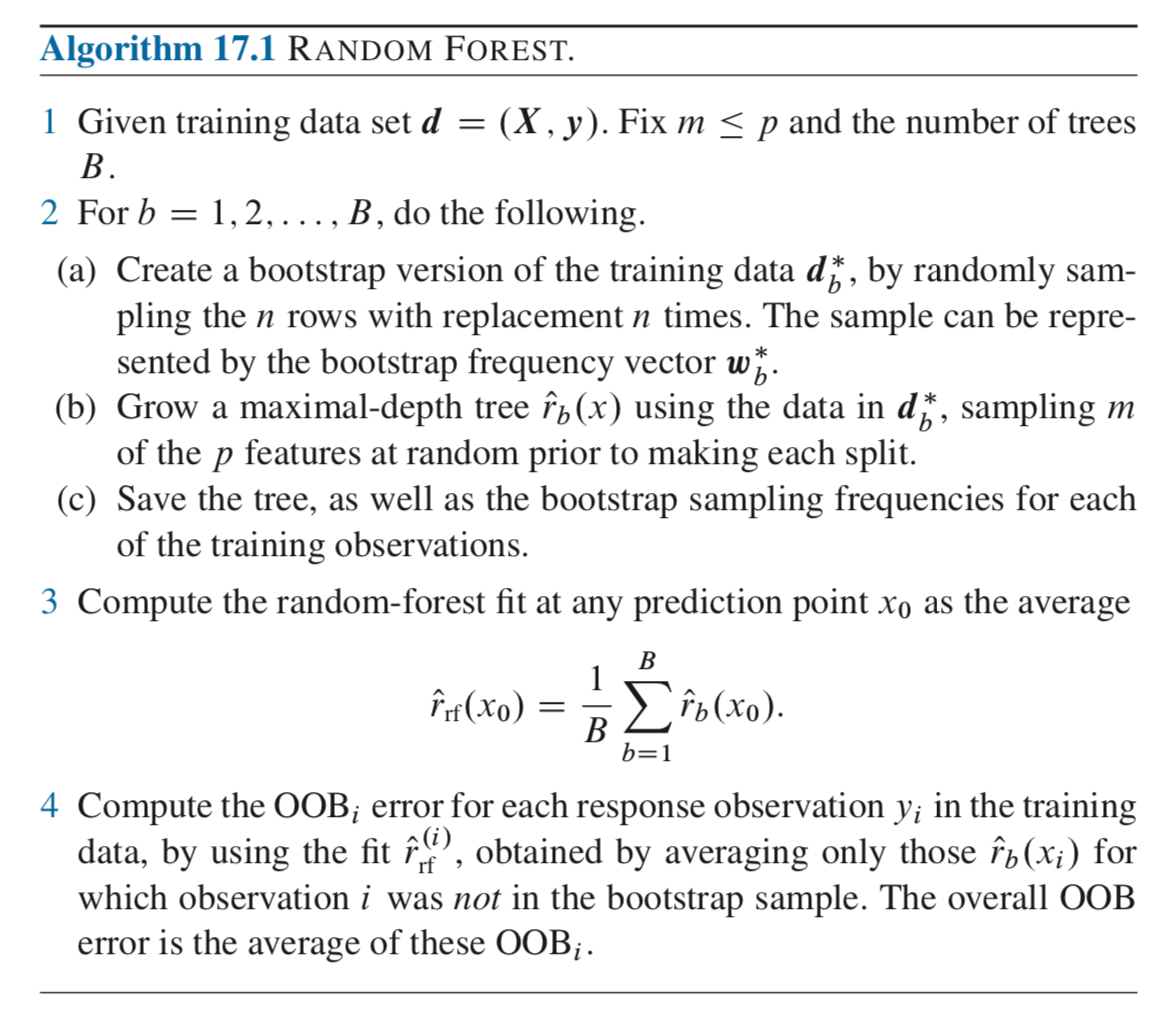

In [33]:
rf_model = build_forest(labels, features, 3, 50, 1.0, 10)
# using 3 random features, 50 trees, 1.0 portion of samples per tree (optional), and a maximum tree depth of 10 (optional)
#
# HINT HERE!!! Check the definition above for the second question of the L8-Assigment, part 2.
#
# apply learned model
confusion_matrix(labelsTest,apply_forest(rf_model,featuresTest)).accuracy

0.6785714285714286

In [34]:
rf_model = build_forest(labels, features, 4, 50, 1.0, 10)
# using 4 random features, 50 trees, 1.0 portion of samples per tree (optional), and a maximum tree depth of 10 (optional)
#
# HINT HERE!!! Check the definition above for the second question of the L8-Assigment, part 2.
#
# apply learned model
confusion_matrix(labelsTest,apply_forest(rf_model,featuresTest)).accuracy

0.6785714285714286

## Boosting 
RF is a special case of additive ensambeles:
$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$

Gradient boosting is a different way to train an ensamble of trees
\begin{align}
\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{align}

$\text{obj} = \sum_{i=1}^n l_i(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i)$

At each step greedily optimises the additive loss-function.

Boosting has many different flavours - common theme reweighing the error at each step (learn from mistakes)

## AdaBoost
![png](tree2.png)

In [35]:
adaerror=Float64[];
for i=1:20
    ada,coef=build_adaboost_stumps(labels,features,i)
    push!(adaerror,confusion_matrix(labelsTest,apply_adaboost_stumps(ada,coef,featuresTest)).accuracy)
end
plot([1:20;],adaerror)



<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5 
 
 
 10 
 
 
 15 
 
 
 20 
 
 
 0.62 
 
 
 0.64 
 
 
 0.66 
 
 
 0.68 
 
 
 0.70 
 
 
 0.72 
 
 
 0.74 
 
 
 
 
 
 
 y1

## Probabilistic classifiers
By renormalising the output of $\hat{G}_b$. Adaboost can bee seen as a probabilistic classifier. The confussion matrix (see above) depends on the value of the threshold. This can be visualised by the ROC curve.

![png](roc.png)

In [36]:
# Lets output probabilities
ada,coef=build_adaboost_stumps(labels,features,10);


In [37]:
# thresholding yields prediction
function thres(x,t)
   if x<t 
        return "No"
    end
    return "Yes"
end

adares=(apply_adaboost_stumps_proba(ada,coef,featuresTest,["Yes","No"]))[:,1];

In [38]:
ts=[0.0:0.05:1.0;]
function rocXY(mat)
   Float64[mat[2,2]/(mat[2,1]+mat[2,2]),mat[1,2]/(mat[1,1]+mat[1,2])]
end
function rocRate(t)
    res=confusion_matrix(labelsTest,map(x->thres(x,t),adares)).matrix *1.0
    rocXY(res)
end
res=hcat([rocRate(t) for t in ts]...)
plot(vec(res[1,:]),vec(res[2,:]))
title!("ROC")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0 
 
 
 0.2 
 
 
 0.4 
 
 
 0.6 
 
 
 0.8 
 
 
 1.0 
 
 
 0.0 
 
 
 0.2 
 
 
 0.4 
 
 
 0.6 
 
 
 0.8 
 
 
 1.0 
 
 
 ROC 
 
 
 
 
 
 
 y1

## Outlook
 
 * variable importance plots a useful diagnostic for trees 
  * in the simplest instance they permuate column in the feature matrix in evaluate the impact on the performance.
 * There are many more boosting algorithms such as XGBoost.jl and  [LightGBM.jl](https://github.com/Allardvm /LightGBM.jl). We can attack the problem above using XGBoost as follows. 

In [39]:
#Pkg.add("XGBoost")

In [40]:
using Compat
#using XGBoost

#bst = xgboost(features, num_round, label = labels, eta = 1, max_depth = 2,
#objective = "binary:logistic")
#predict(bst, featuresTest)

# Bonus exercise 
The visualisaiions of trees is done purely in DecisionTree.jl. I made a quick attempt at rectifying this using [GraphViz.jl](https://github.com/Keno/GraphViz.jl). Feel free to come up with a nice visualisation and submit this to DecisionTree.jl

In [48]:
#using GraphViz
#Graph("""
#graph graphname {
#     // The label attribute can be used to change the label of a node
#     a [label="Foo"];
#     // Here, the node shape is changed.
#     b [shape=box];  // These edges both have different line properties
#     a -- b -- c [color=blue];     b -- d [style=dotted];}
#""")
#Graph(graphstring)

In [100]:
donen=[]
notdone=[(model,1)]
j=1
graphstring="graph tree {"
edgestring=""
while length(notdone)>0
    el,i=pop!(notdone)
   push!(donen,el) 
    graphstring*=  "p$(i) [label=\"$(featurenames[el.featid])\"];"*"\n"
    if typeof(el.left)!=DecisionTree.Leaf 
        j+=1
        push!(notdone,(el.left,j))
        edgestring*="p$(i)--p$(j);"
    else
        j+=1;
        graphstring*=  "p$(j) [label=\"$(featurenames[el.featid])\"];"*"\n"
        
    end
      if typeof(el.right)!=DecisionTree.Leaf 
        j+=1

        push!(notdone,(el.right,j))

        edgestring*="p$(i)--p$(j);"
    end
    
end
graphstring*=edgestring*"}"
mutable struct rd
    j::Int64
    graphstring::String
    edgestring::String
    featurenames
end

r=rd(1,"digraph tree{","p1",featurenames)

function GraphVizString(g,r::rd)

    i=r.j
    if(typeof(g)==DecisionTree.Leaf )
        r.graphstring*="p$(i) [shape=box];"
        r.edgestring*="->$(r.j);"
        return r;
    else 
        r.graphstring*="p$(i) [label=\"$(featurenames[g.featid])\"];\n"
        r.j+=1
        r.edgestring*="->p$(r.j)"
        r=GraphVizString(g.left,r)
        r.j+=1
        r.edgestring*="\n p$(i)"
        r=GraphVizString(g.right,r)
        return r;
        
    end

    
end

r=rd(1,"digraph tree{","p1",featurenames)

function GraphVizString(g,r::rd)

    i=r.j
    if(typeof(g)==DecisionTree.Leaf )
        r.graphstring*="p$(i) [shape=box];\n"
        return r;
    else 
        r.graphstring*="p$(i) [label=\"$(featurenames[g.featid])\"];\n"
        r.j+=1
        r.edgestring*="p$(i)->p$(r.j);\n"
        r=GraphVizString(g.left,r)
        r.j+=1
        r.edgestring*="p$(i)->p$(r.j);\n"
        r=GraphVizString(g.right,r)
        return r;
        
    end

    
end

LoadError: [91mtype Ensemble has no field featid[39m